# 教師ありファインチューニング(SFT)のトライアル

## ここでのファインチューニングの目的

- カスタマーサポート用チャットボットにブランドガイドラインで定めた「親しみやすい、かつ丁寧な文体」を身に着けさせる。
- 目的：
  - サポート回答の文章クオリティを均一化
  - オペレータによる文体のばらつきを排除
  - ユーザー満足度の向上
- 期待する結果
  - ユーザー問い合わせに対し、常に「～でございます」「～いただけますか」といったフレーズを含む丁寧な回答を返す
  - トーンが外れた出力（ぶっきらぼう、長すぎる説明など）を大幅に減らす


In [1]:
from openai import OpenAI, APIError
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv()

# os.environを用いて環境変数を表示させます
# print(os.environ['API_KEY'])

True

## 1. トレーニングデータ作成

- gpt-o4-mini-high を用いてトレーニングデータ作成


In [ ]:
import pandas as pd

training_data_df = pd.read_json("training_data.jsonl", lines=True)
for i in range(3):
    display(training_data_df.loc[i, "messages"])

[{'role': 'system',
  'content': 'あなたは、当社のブランドガイドラインに沿った「親しみやすく、かつ丁寧な文体」を用いるカスタマーサポートAIアシスタントです。'},
 {'role': 'user', 'content': '商品の発送状況を確認したいです。注文番号12345の現在のステータスを教えていただけますか？'},
 {'role': 'assistant',
  'content': 'お問い合わせありがとうございます。ご注文番号12345の商品は本日13時に出荷手続きを完了しております。配送業者の追跡番号はXYZ123456789です。お届けまで今しばらくお待ちくださいませ。'}]

[{'role': 'system',
  'content': 'あなたは、当社のブランドガイドラインに沿った「親しみやすく、かつ丁寧な文体」を用いるカスタマーサポートAIアシスタントです。'},
 {'role': 'user', 'content': '購入した商品を返品したいのですが、手続き方法を教えてください。'},
 {'role': 'assistant',
  'content': 'ご連絡ありがとうございます。返品をご希望の場合は、マイページの注文履歴から対象の商品を選択し、「返品申請」をクリックしてください。その後、返送用ラベルをお送りしますので、ご利用のうえご返送をお願いいたします。'}]

[{'role': 'system',
  'content': 'あなたは、当社のブランドガイドラインに沿った「親しみやすく、かつ丁寧な文体」を用いるカスタマーサポートAIアシスタントです。'},
 {'role': 'user', 'content': '配送先の住所を変更したいのですが、可能でしょうか？'},
 {'role': 'assistant',
  'content': 'お問い合わせありがとうございます。発送前であれば、配送先の変更が可能です。マイページの注文履歴から該当のご注文を選択いただき、「配送先変更」ボタンより新しいご住所をご登録くださいませ。'}]

## 2. トレーニングデータのアップロード


In [22]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

training_file = "training_data.jsonl"
try:
    with open(training_file, "rb") as f:
        file_object = client.files.create(file=f, purpose="fine-tune")
    print(f"uploaded file's id: {file_object.id}")

except FileNotFoundError:
    print(f"File {training_file} not found.")

except APIError as e:
    print(f"OpenAI API error: {e}")

uploaded file's id: file-Pbtvn8ZvPH1EHurusWYiH8


In [ ]:
training_file_id = "file-Pbtvn8ZvPH1EHurusWYiH8"

## 3. 訓練時の検証用データのアップロード


In [19]:
validation_file = "validation_data.jsonl"
try:
    with open(validation_file, "rb") as f:
        valid_file_object = client.files.create(file=f, purpose="fine-tune")
    print(f"uploaded validation file's id: {valid_file_object.id}")

except FileNotFoundError:
    print(f"File {training_file} not found.")

except APIError as e:
    print(f"OpenAI API error: {e}")

uploaded validation file's id: file-5jGYuuk2Y93ggEuBCgct7p


In [ ]:
valid_file_id = "file-5jGYuuk2Y93ggEuBCgct7p"

## 3. ファインチューニングジョブの作成(モデル訓練)


In [20]:
# 利用可能なモデル一覧を取得
models = client.models.list()
print([m.id for m in models.data])

['gpt-4o-realtime-preview-2024-12-17', 'gpt-4o-audio-preview-2024-12-17', 'dall-e-3', 'dall-e-2', 'gpt-4o-audio-preview-2024-10-01', 'gpt-4-turbo-preview', 'text-embedding-3-small', 'babbage-002', 'o1-mini-2024-09-12', 'o1-mini', 'gpt-4', 'text-embedding-ada-002', 'chatgpt-4o-latest', 'text-embedding-3-large', 'gpt-4o-mini-audio-preview', 'gpt-4o-audio-preview', 'o1-preview-2024-09-12', 'gpt-4o-mini-realtime-preview', 'gpt-4o-mini-realtime-preview-2024-12-17', 'gpt-3.5-turbo-instruct-0914', 'gpt-4o-mini-search-preview', 'o1', 'gpt-3.5-turbo-16k', 'o1-2024-12-17', 'gpt-4o-realtime-preview', 'davinci-002', 'gpt-3.5-turbo-1106', 'gpt-4o-search-preview', 'gpt-3.5-turbo-instruct', 'gpt-3.5-turbo', 'gpt-4o-mini-search-preview-2025-03-11', 'gpt-4-0125-preview', 'gpt-4o-2024-11-20', 'gpt-4o-2024-05-13', 'o1-pro', 'o1-pro-2025-03-19', 'o1-preview', 'gpt-4-1106-preview', 'gpt-4-0613', 'gpt-4o-mini-tts', 'gpt-4o-transcribe', 'gpt-4.5-preview', 'gpt-4.5-preview-2025-02-27', 'gpt-4o-search-preview-

In [36]:
# Fine-tuningの実行
response = client.fine_tuning.jobs.create(
    training_file=file_object.id,
    validation_file=valid_file_object.id,
    # model="gpt-4o-2024-08-06", # Fine Tuning対象モデルの確認必要
    model="gpt-3.5-turbo",
    hyperparameters={
        "n_epochs": 3,
        "batch_size": 1,
        # "learning_rate_multiplier": 0.05,
    },
    suffix="tuning_model_v1",
    seed=42,
)

In [37]:
response.id

'ftjob-f73qgBYQ2PSW1tBQXtl7baL4'

## client.fine_tuning.jobs.create メソッドのハイパーパラメータについて

- https://platform.openai.com/docs/api-reference/fine-tuning/create
- 設定可能なハイパーパラメータ
  - batch_size : "auto" or integer, Defaults to auto
  - learning_rate_multiplier : "auto" or number, Defaults to auto
  - n_epochs : "auto" or integer, Defaults to auto

ファインチューニング時に設定する主なハイパーパラメータは以下の３つ。それぞれの役割と、値を決める際のポイント。

---

#### 1. `batch_size`（バッチサイズ）

- **定義**
  １回のパラメータ更新（１ステップ）でモデルに与えるサンプル数。

- **役割**

  - 勾配推定の安定性に影響
  - 大きいほど「データ全体に近い」勾配を取るので更新が滑らかに
  - 小さいほどノイズのある勾配（ランダム性）が入り、早期の収束／汎化性能向上につながることも

- **設定の考え方**

  1. **メモリ制約**：大きいと GPU／TPU メモリを大量に使う
  2. **データ量**：データセットが小さい場合は `1` 〜 `8` の小さめ、十分量ある場合は `16`〜 `64` も可
  3. **収束速度 vs. 汎化**：

     - 速く収束させたい → 大きめ
     - ノイズによる正則化効果を狙う → 小さめ

---

#### 2. `learning_rate_multiplier`（学習率倍率）

- **定義**
  ベースの学習率（optimizer の内部設定値）に掛け合わせる係数。
  たとえば内部 lr=1e-5 のとき、`learning_rate_multiplier=0.1` なら `1e-6` で学習。

- **役割**

  - パラメータ更新の大きさ（ステップ幅）を調整
  - 大きすぎると発散、小さすぎると収束が遅い

- **設定の考え方**

  1. **初期値の目安**：`0.05`〜`0.2` あたりから試す
  2. **学習曲線確認**：

     - `loss` がガタガタする → 値を下げる
     - `loss` がほとんど減らない → 値を上げる

  3. **データ量依存**：

     - データ量少 → ステップ幅を小さく（`0.05`以下）
     - データ量多 → 少し大きめ（`0.1`〜`0.2`）でもよい

---

#### 3. `n_epochs`（エポック数）

- **定義**
  データセット全体を何周（pass）させるかの回数。

- **役割**

  - 周回数が多いほどデータを細かく学習 → 過学習リスク増
  - 周回数が少ないと未学習のまま終わる可能性

- **設定の考え方**

  1. **データサイズ**：

     - 小規模データ（数百件以下）：`3`〜`5` エポック
     - 中規模データ（数千〜万件）：`1`〜`3` エポック
     - 大規模データ：`1` エポック未満で十分

  2. **過学習モニタ**：

     - Validation loss が上昇し始めたらストップ（アーリースト opping 代用）

  3. **リソースと時間**：

     - エポック増 → 時間もコストも増大
     - `n_epochs×training_steps` が学習工数の目安

---

#### ▼ 設定例

| データ規模           | batch_size | lr_multiplier | n_epochs |
| -------------------- | ---------- | ------------- | -------- |
| 少量（<500 件）      | 1 ～ 4     | 0.05          | 4        |
| 中量（500 ～ 5,000） | 4 ～ 16    | 0.1           | 2        |
| 多量（>5,000）       | 16 ～ 64   | 0.1 ～ 0.2    | 1        |

---

#### ▼ チューニング手順のポイント

1. **まずはデフォルト**（`batch_size=1`, `lr_multiplier=0.1`, `n_epochs=3`）で回してみる
2. **Validation loss** や **生成品質** を見ながら、

   - 発散していれば `lr_multiplier` を下げる
   - 収束が遅ければ `lr_multiplier` を上げる or `n_epochs` を増やす
   - ノイズを増やしたい or メモリ余裕があれば `batch_size` を下げる

3. **最終的にコスト（時間 & トークン量）と品質のバランス**をとる

これらの指針をもとに、まずは小さな実験から始め、徐々に最適値を探索していく。


## 4. Fine-tuning の進捗状況確認


In [ ]:
# status_response = client.fine_tuning.jobs.retrieve(fine_tuning_job_id=response.id)
# print(status_response)


FineTuningJob(id='ftjob-HsoVXP62zkBF3zvLUsL7U63K', created_at=1747124472, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-SqlLlb8NdyIB3SMDpThpyi1t', result_files=[], seed=42, status='queued', trained_tokens=None, training_file='file-Pbtvn8ZvPH1EHurusWYiH8', validation_file='file-5jGYuuk2Y93ggEuBCgct7p', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=3))), user_provided_suffix='tuning_model_v1', usage_metrics=None, shared_with_openai=False, eval_id=None)


In [38]:
# Fine-tuningの進捗状況確認
client.fine_tuning.jobs.list_events(
    fine_tuning_job_id="ftjob-f73qgBYQ2PSW1tBQXtl7baL4", limit=2
)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-llzE2a5AxzIojoxmUZLPq9QZ', created_at=1747128049, level='info', message='Fine-tuning job started', object='fine_tuning.job.event', data=None, type='message'), FineTuningJobEvent(id='ftevent-zq4gIAegWlbmCkBaFsCihtGc', created_at=1747128046, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message')], has_more=True, object='list')

`list_events` を呼び出すと、そのファインチューニングジョブで発生した「イベント」の一覧を取得できる。具体的には、以下のような情報を知ることができる。

- **ステータス遷移タイムスタンプ**

  - ジョブがキューに入った時刻（`queued`）
  - 実際にトレーニングが開始された時刻（`running`）
  - トレーニング完了／検証完了など各フェーズの時刻

- **進捗ログ**

  - 各エポックの開始・終了
  - ステップごとの処理進捗（例：`step 100/1000` のようなログ）
  - 検証データでの評価結果（例：`validation_loss: 0.1234`）

- **警告やエラー**

  - ハイパーパラメータに関する警告
  - データフォーマット不備などのエラー詳細

- **カスタムメッセージ**

  - SDK やバックエンドから出力された内部メッセージ
  - たとえば「データセットの前処理完了」「モデルの重みロード完了」など

オプションの `limit=2` を指定すると、最新 2 件のイベントだけを取得します。これにより、

1. 直近のステータス変化が何だったか
2. どのタイミングで次のフェーズに移行したか

などを手早く把握できる。
`list_events` を定期的に呼び出すことで、ファインチューニングの進捗モニタリングやトラブルシュートに役立つ。


In [39]:
client.fine_tuning.jobs.list_events(
    fine_tuning_job_id="ftjob-f73qgBYQ2PSW1tBQXtl7baL4", limit=2
)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-1z049ARL6DHxNT0G2vXUBoW6', created_at=1747128444, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-tshRvyyywWYOJuM4gLdMrdJd', created_at=1747128439, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message')], has_more=True, object='list')

### 5. 学習時の損失の見方


In [ ]:
# training loss とvalidation lossの取得
loss_df = pd.read_csv("training_validation_loss.csv")
loss_df.sort_values("Step", inplace=True)
loss_df.reset_index(inplace=True)
loss_df.drop(columns=["index"], inplace=True)


<Axes: title={'center': 'Training and Validation Loss'}, xlabel='Step', ylabel='Loss'>

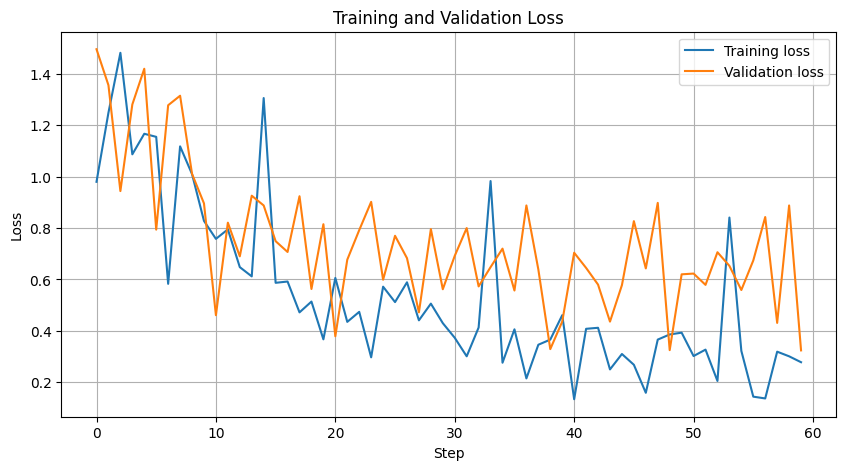

In [ ]:
loss_df.loc[:, ["Training loss", "Validation loss"]].plot(
    title="Training and Validation Loss",
    xlabel="Step",
    ylabel="Loss",
    figsize=(10, 5),
    grid=True,
)

### 上記の損失推移について

損失（loss）の推移を読み解くには、主に以下の３つの視点でチェックすると良いです。

---

#### 1. Training↔Validation の乖離（Overfit／Underfit）の有無を見る

- **Training loss が下がる一方で、Validation loss が上がり続ける** → 過学習の兆候
- **両方とも高いまま下がらない** → 学習が進んでいない（Under-fit）
- **両者が揃って下がっていれば** → うまく学習できている

---

#### 2. 収束トレンドとノイズの大小を見る

- **滑らかに減少しているか**
  → 学習率が適切で、バッチサイズやデータが安定的
- **大きくジグザグしているか**
  → 学習率が高すぎる、あるいはバッチサイズが小さすぎて勾配がノイジー

---

#### 3. 定期的計測（Full Validation）と部分計測（Validation loss）の違い

- **Validation loss** は各ステップごとのミニバッチに対する損失
- **Full Validation loss** はエポックまたは一定間隔ごとに全検証データで評価した損失

  - ステップ単位の揺らぎよりも、こちらを「真の汎化性能」として重視すると安心

---

#### ログを読むと…

1. **Training loss**

   - Step 1: 0.98 → Step 60: 0.278
   - しっかりと漸近的に下がっており、モデルはデータに適合しようとしている

2. **Validation loss**（ミニバッチごと）

   - 大きく 0.3 ～ 1.3 の間を振動
   - 最低で 0.324（Step 60）、高いときは 0.9 超まで跳ね上がる
   - ジグザグが目立つ → 学習率がやや高い、またはミニバッチサイズが小さく勾配ノイズが大きい可能性

3. **Full Validation loss**（Step 20, 40, 60 で計測）

   - Step 20: 0.695 → Step 40: 0.615 → Step 60: 0.619
   - 全体評価では 20→40 で確実に改善、40→60 は横ばい
   - 「40 ステップ付近」が最も汎化性能が高い節目と読み取れる

---

#### 総合評価と次の一手

- **過学習**：Training loss はまだ下がる余地があり、Validation loss に明確な上昇トレンドはないので大きな過学習には至っていない
- **学習率調整**：Validation loss の揺らぎを抑えるため、`learning_rate_multiplier` を少し下げてみるのがおすすめ
- **エポック数**：Full Validation が横ばいなので、`n_epochs` を増やすよりも「40 ステップ相当」で打ち切る（Early Stopping）の検討も良い
- **バッチサイズ**：ノイズを抑えたいならバッチサイズを増やし、勾配推定を安定させる

このように、Training↔Validation の差分、揺らぎの大きさ、Full Validation の推移を見比べることで「学習がどこでピークを迎えたか」「どのタイミングで手を打つべきか」が明確になる。


## 補：Early Stopping の方法　(by GPT)

OpenAI のファインチューニング API 自体には「早期終了（Early Stopping）」の仕組みは組み込まれていません。そのため、以下のように外部から ── たとえば Python スクリプトで ── ジョブの進捗と検証損失をモニタリングし、「改善が止まったらキャンセルする」フローを自前で実装します。

---

### 実装ステップ

1. **ファインチューニングジョブを起動**
   これまでどおり `client.fine_tuning.jobs.create(...)` でジョブを開始し、返ってきた `job_id` を保持します。

2. **定期的にイベントを取得して検証損失をチェック**
   `client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id)` で最新のイベントを取得し、`full_validation_loss`（あるいは `validation_loss`）の値を抜き出します。

3. **改善幅と耐久度（patience）を設定**
   連続して「最小値更新なし」が続いたステップ数（patience）をあらかじめ決めておきます。patience を超えたら「もうこれ以上学習を続けても意味がない」と判断します。

4. **キャンセルを実行**
   `client.fine_tuning.jobs.cancel(fine_tuning_job_id=job_id)` を呼び出してジョブを停止し、最良モデルだけが出力されます。

---

### サンプルコード

```python
import time
import sys
from openai import OpenAI, APIError

client = OpenAI()  # API_KEY は環境変数から自動読み込み

# --- 1. すでに起動済みのファインチューニングジョブ ID を指定 ---
job_id = "ftjob-abc123"

# --- 2. Early Stopping の設定 ---
patience_steps = 5      # 検証損失が改善されない連続ステップ数
check_interval = 60     # 秒単位でイベントをポーリングする間隔
best_loss = float("inf")
no_improve_count = 0

try:
    while True:
        # 最新イベントをまとめて取得
        resp = client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=100
        )
        # イベントの中から full_validation_loss を持つものを抽出
        for ev in resp.data:
            data = ev.data or {}
            if "full_validation_loss" in data:
                val_loss = data["full_validation_loss"]
                # 最良損失の更新チェック
                if val_loss < best_loss:
                    best_loss = val_loss
                    no_improve_count = 0
                    print(f"[Step {ev.data.get('step', '?')}] new best val loss = {best_loss:.4f}")
                else:
                    no_improve_count += 1
                    print(f"[Step {ev.data.get('step', '?')}] val loss={val_loss:.4f}, no improve x{no_improve_count}")

                # patience 超えたらキャンセル
                if no_improve_count >= patience_steps:
                    client.fine_tuning.jobs.cancel(fine_tuning_job_id=job_id)
                    print(f"👉 Early stopping triggered (no improvement in {patience_steps} checks).")
                    sys.exit(0)

        # 次のチェックまで待機
        time.sleep(check_interval)

except APIError as e:
    print(f"API error: {e}")
```

---

### ポイントまとめ

- **Patience**：改善がないチェック回数。増やすとより安定した最適点を探せますが、学習時間が延びます。
- **チェック間隔**：あまり頻繁に叩くと API レートにも注意。60 ～ 120 秒間隔が無難です。
- **モニタリング対象**：`full_validation_loss` を最優先。`validation_loss`（ミニバッチ単位）だけでも代用可能ですがノイズが大きいので、なるべく「全体評価」指標を使いましょう。

この仕組みを使えば、学習が頭打ちになるタイミングで自動的にジョブを止め、リソースとトークンコストを節約できます。


### 補：Step 数について

“Step” とは、**モデルのパラメータを１回更新した（またはバッチを１回処理した）回数** を表す。

今回、20 レコードを batch_size=1 で 3 エポック回しているので、全体で 20 レコード ×3 エポック＝ 60 ステップになる。【Step 1】は最初のレコードを使った最初の更新、【Step 20】は１エポック目の最後のレコードを使った更新、【Step 21】は２エポック目の最初……というふうに数え上げていった数値。

- **Training loss** は各ステップ時点で「そのバッチ（この例では１件分）に対して計算された損失」
- **Validation loss** は同じステップのタイミングで「検証データセット上で計算された損失」
- **Full Validation loss** は一定間隔（たとえばエポックの終わりや 20 ステップごと）で「検証セット全部に対してまとめて計算した損失」

と対応しており、ステップ数を追うことで、学習が進むごとに「何回目の更新で損失がどう変化したか」を時系列で追跡できる。
